참고1 : [tensorflow tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko)  
참고2 : [Practice](https://8888-whdt2ex24fevojzbph5ikvwqc.e.aiffel-3.ainetwork.ai/notebooks/aiffel/%5BE-19%5DPractice.ipynb)  
참고3 : GradientTape : forward propagation 을 tape에 기록해가면서 진행하는 방식


진행 flow  
1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요.
(어떠한 방법을 사용했는지 적어주세요.)
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.
3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.
5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.


In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

## 1) Dataset info.
1. trainset : 1000 // valset 5
2. 각각의 데이터는 real_image와 segmented image 쌍으로 정보로 이루어져 있음. 이미지 분할 후 **U-Net Generator** 이용하여 segmented image로부터 real_image를 얼마나 성공적으로 생성해내느냐가 프로젝트 목표.
3. 이미지 크기는 256, 512, 3 이므로 분할 후 (256,256,3) 의 크기로 input으로 입력예정.

In [3]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'
print("number of val examples :", len(os.listdir(data_path)))
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of val examples : 5
number of train examples : 1000


(256, 512, 3)

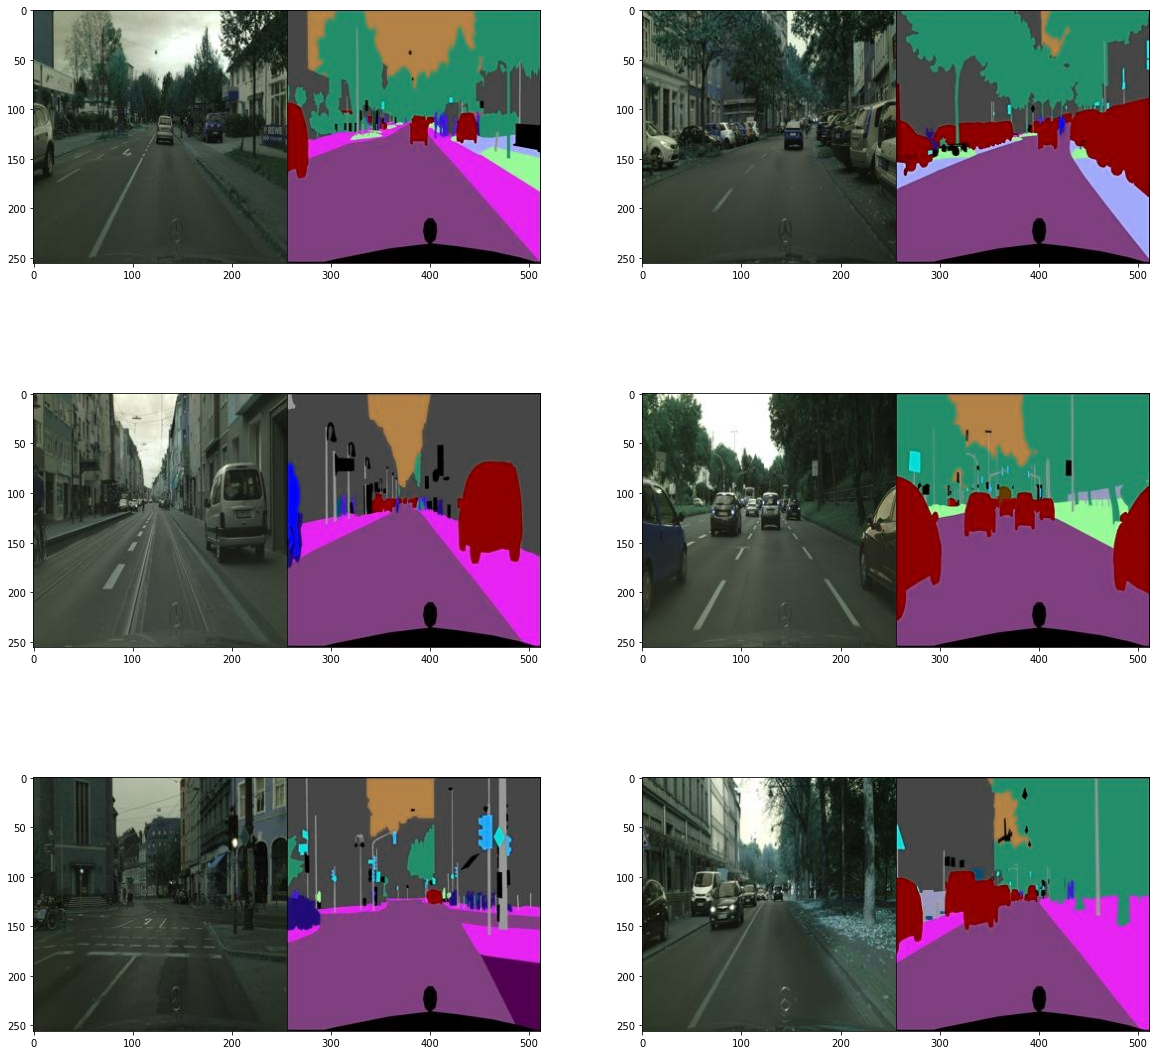

In [6]:
plt.figure(figsize=(20,20))
for i in range(1,7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)
img.shape

## 2) preprocessing
1. normalize([-1,1]) 와 시각화를 위한 denormalized 함수 정의, 학습과 시각화에 적절히 활용
2. `real_img` 와 `segmented` 로 분리하여 image load하는 load_img함수 이용
3. data augmentation

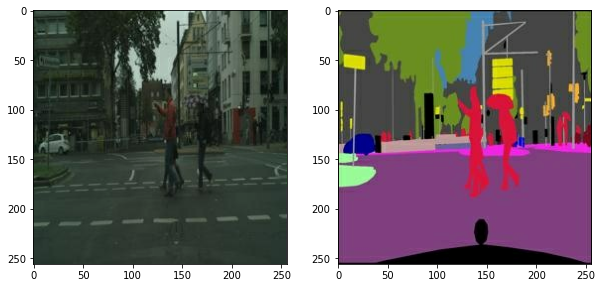

In [9]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img,3)
    
    # 이미지 스케치와 채색으로 분리
    w = tf.shape(img)[1]//2
    real_img = img[:,:w,:]
    real_img = tf.cast(real_img, tf.float32)
    
    segmented = img[:,w:,:]
    segmented = tf.cast(segmented, tf.float32)
    
    return normalize(real_img), normalize(segmented)

f= data_path + os.listdir(data_path)[1]
real_img, segmented = load_img(f)

plt.figure(figsize=(10,7))

plt.subplot(1,2,1); plt.imshow(denormalize(real_img))
plt.subplot(1,2,2); plt.imshow(denormalize(segmented))


> 오른쪽 이미지로부터 왼쪽 이미지를 생성해 냄에 유의하자.

### 3. data augmentation

1) 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.  
2) 1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)  
3) 2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)  
4) 3.의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)  
5) 4.의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)  
6) 5.의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)  

In [10]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   


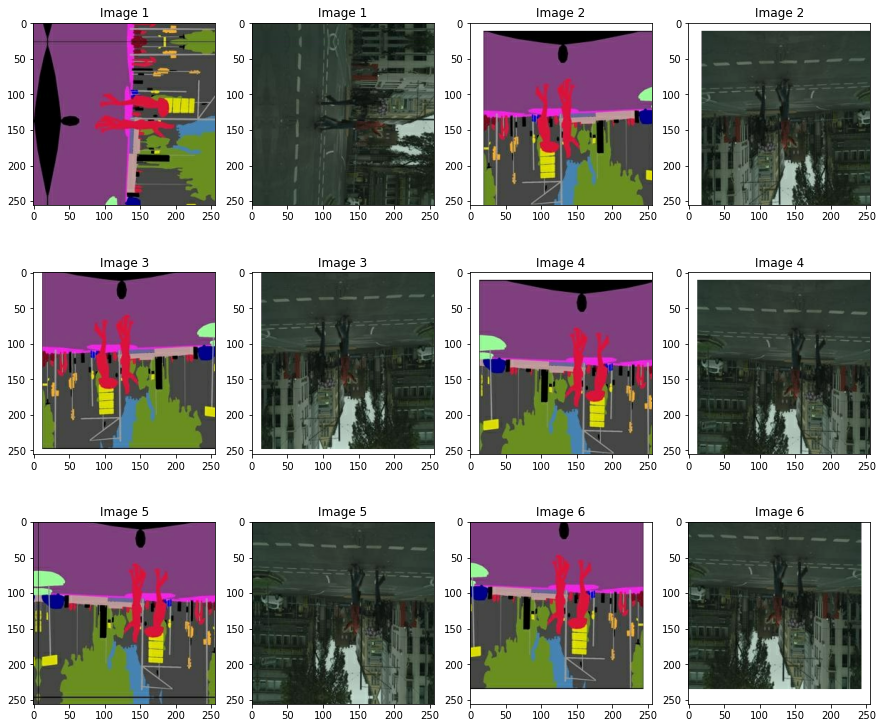

In [12]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_segment, augmented_real = apply_augmentation(segmented, real_img)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_segment)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_real)); plt.title(f"Image {img_n}")
    img_n += 1

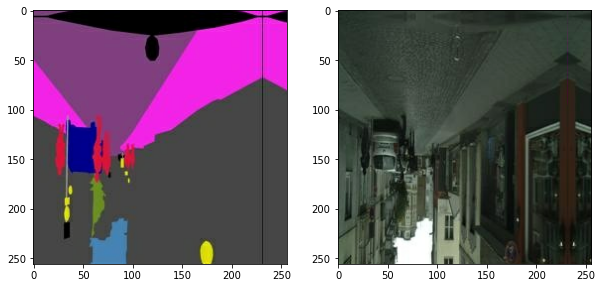

In [13]:
from tensorflow import data

def get_train(img_path):
    real_img, segmented = load_img(img_path)
    real_img, segmented = apply_augmentation(real_img, segmented)
    return real_img, segmented

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
real_img, segmented = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,2); plt.imshow(real_img[0].astype(np.uint8))
plt.subplot(1,2,1); plt.imshow(segmented[0].astype(np.uint8))

## 3) U-Net 구현
1) Generator 구현  
- encoder
- decoder  

2) Discriminator

2) conditional layer -> skip connection

In [14]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self,n_filters, use_bn = True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)
        
    def call(self,x):
        x = self.conv(x)
        if self.use_bn: # batchnorm 쓸건지 말건지 Boolean Type으로
            x = self.batchnorm(x)
        return self.lrelu(x)

In [16]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64, 128, 256, 512, 512, 512, 512, 512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i==0:
                self.blocks.append(EncodeBlock(f, use_bn = False))
            else : 
                self.blocks.append(EncodeBlock(f))
    
    def call(self,x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self,input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
    
    

In [17]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

- decoder

In [18]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

In [19]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

encoder와 decoder를 연결하여 Generator 구성

In [20]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator,self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_summary(self, input_shape = (256,256,3)): #Pokemon
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
    
EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [21]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

### Unet Generator

- skip connection을 feature라는 리스트를 만들어 구현!  
- feature[:-1] : 마지막 디코더는 연결 안함

In [23]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [24]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

### 2) Discriminator

In [29]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

__init__() 에서  

1)필터의 수(n_filters)  
2) 필터가 순회하는 간격(stride)  
3) 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad)  
4) BatchNorm의 사용 여부(use_bn)  
5) 활성화 함수 사용 여부(act)가 설정 가능

In [26]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [27]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [28]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

Now generate noise

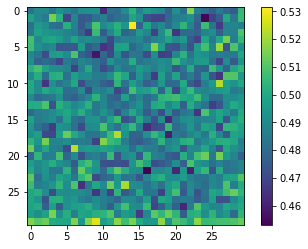

In [30]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

### Model fitting

L1(Mean square error) + GAN

In [54]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


In [55]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)


weight update

In [56]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [57]:
EPOCHS = 15 #약 30분 정도 소요 됩니다.

generator = UNetGenerator()
discriminator = Discriminator()
g_list, l1_list, d_list = [], [], []


for epoch in range(1, EPOCHS+1):
    for i, (real, segmented) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segmented,real)
        
        
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            g_list.append(g_loss)
            l1_list.append(l1_loss)
            d_list.append(d_loss)
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8432                     
L1_loss:0.3298                     
Discriminator_loss:1.3476

EPOCH[1] - STEP[20]                     
Generator_loss:0.9620                     
L1_loss:0.2393                     
Discriminator_loss:1.2642

EPOCH[1] - STEP[30]                     
Generator_loss:0.8015                     
L1_loss:0.2500                     
Discriminator_loss:1.4610

EPOCH[1] - STEP[40]                     
Generator_loss:0.8304                     
L1_loss:0.1944                     
Discriminator_loss:1.1877

EPOCH[1] - STEP[50]                     
Generator_loss:0.9131                     
L1_loss:0.2571                     
Discriminator_loss:1.1019

EPOCH[1] - STEP[60]                     
Generator_loss:1.0223                     
L1_loss:0.1680                     
Discriminator_loss:1.0694

EPOCH[1] - STEP[70]                     
Generator_loss:1.0292                     
L1_loss:0.2095                    

## Testing - valset , and visualization(10epochs)

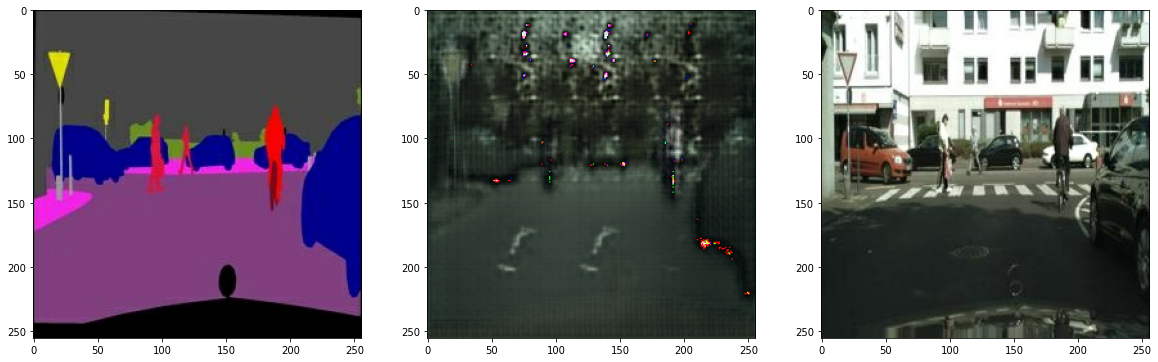

In [36]:
test_ind = 1

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'

f = data_path + os.listdir(data_path)[test_ind]
real, seg = load_img(f)

pred = generator(tf.expand_dims(seg, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,3); plt.imshow(denormalize(real))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,1); plt.imshow(denormalize(seg))

> 복원된 사진의 Quality가 좋지는 않다. 10epochs 만 돌려서 그런듯하다.

## Testing - valset , and visualization(15epochs)

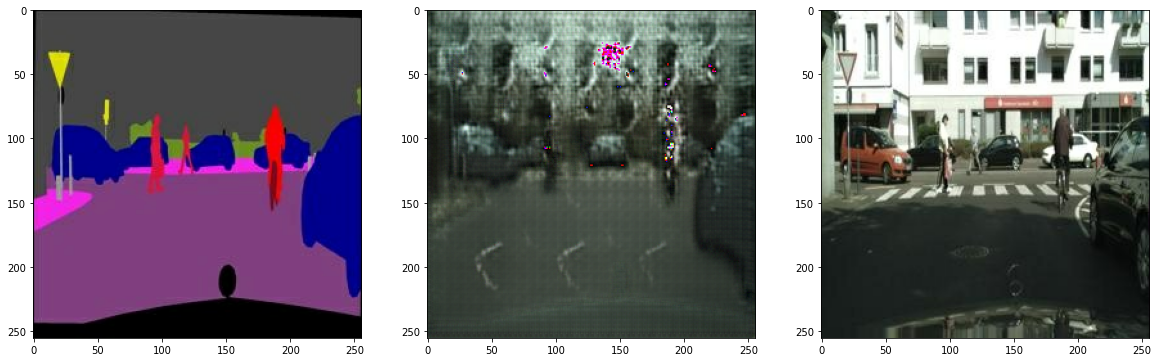

In [58]:
test_ind = 1

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'

f = data_path + os.listdir(data_path)[test_ind]
real, seg = load_img(f)

pred = generator(tf.expand_dims(seg, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,3); plt.imshow(denormalize(real))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,1); plt.imshow(denormalize(seg))

15 epoch에서 조금 더 개선된 그림을 보이지만 여전히 노이즈가 있는 부족한 사진이다.
특정 지점에서 붉은 기운은 디테일을 복원한 것을 보여준다.


<Figure size 1440x2160 with 0 Axes>

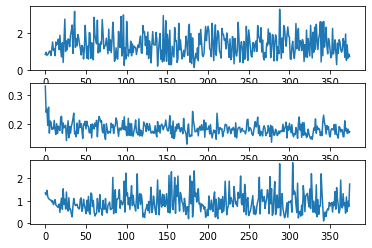

In [59]:
plt.figure(figsize=(20,30))
fig, ax = plt.subplots(3,1)

ax[0].plot(g_list)
ax[2].plot(d_list)
ax[1].plot(l1_list)


Generator Loss : 2 아래쪽을 반복하는 것으로 확인된다. epoch이 반복되도 크게 개선되지는 않는다.
Discriminator Loss : 0.2 언저리를 맴돈다. 0.5로 다가가야 이상적인데, 아직은 잘 구분하는 것을 알 수 있다.
L1 Loss : 역시 1~2 사이에서 크개 개선되지는 않는다.

# 회고
- 데이터셋 및 학습 epoch의 부족으로 인하여 위와 같은 결과를 보인 것으로 사료된다. conditional 한 생성모델인 만큼, 많은 학습량이 요구된다고 생각한다.
- 차후에 기회가 된다면 더 많은 학습량을 통해 개선되는 결과를 확인하여 보고 싶다.
